In [208]:
import numpy as np
from scipy import constants
import tabulate
import pandas as pd
import matplotlib.pyplot as plt
from IonChainTools import calcPositions,lengthScale,ion_position_potential
from tweezer_functions import *
from scipy.optimize import fsolve

In [209]:
#Constants in SI units
eps0 = constants.epsilon_0 
m = 39.9626*constants.atomic_mass
c = constants.c
e = constants.e
hbar = constants.hbar
pi = np.pi

In [210]:
# setting up parameters that we're not changing
NA = 0.1
tweezer_wavelength = 532e-9
omega_tweezer = 2*pi*c/tweezer_wavelength
df = pd.read_csv("S_P_only.csv",sep = ",",encoding = "UTF-8")
lambdares = np.array(df["wavelength (nm)"])*1e-9
omega_res = 2*pi*c/lambdares
linewidths = np.array(df["A_ki (s^-1)"])
lifetimes = linewidths

# Figuring out what % of the beam waist you need to be in to still be feeling a quadratic force

In [211]:
#finding out the diameter(FWHM) I should make the beam
ionspacing = ion_spacing(3,1*2*pi*1e6)
print(ionspacing)

[array([-4.79258560e-06,  8.03686927e-20,  4.79258560e-06]), [4.792585602933644e-06, 4.792585602933404e-06]]


so for a 5 ion chain of 1 MHz rf axial trapping frequency, 

In [212]:
def pot_derivative_with_tweeze(x, omega_rf_axial, omega_tw_radial, tweezed_ion, displacement):
    """
    derivative of the potential energy of the ion chain, use this to find positions of ions in the trap
    This one is specifically for tweezing one ion in the chain
    inputs:

    x: list of ion positions
    omega_rf_axial: the rf axial trapping frequency [2*pi*Hz]
    omega_tw_radial: the tweezer radial trapping frequency [2*pi*Hz]
    tweezed_ion: Ion number for the tweezed ion
    displacement: distance between the tweezer beam center and position of the tweezed ion
    """
    N = len(x)
    A = 1/2 * m * omega_rf_axial**2
    B = (e**2) /(4 * pi * eps0)
    C = 1/2 * m * omega_tw_radial**2
    
    return [A*(x[m]) 
            - sum([B / (abs(x[m] - x[n])**2) for n in range(m) if x[m] != x[n]])  # Avoid division by zero
            + sum([B / (abs(x[m] - x[n])**2) for n in range(m+1, N) if x[m] != x[n]])  # Avoid division by zero
            + C*(x[tweezed_ion] - displacement) if m == tweezed_ion else 0  # Only apply tweezer potential to the tweezed ion
            for m in range(N)]

# Example usage
N = 3
x = np.empty(N)
omega_rf_axial = 1 * 2 * pi * 1e6
U = 5e-3
beam_waist = 5e-6
omega_tw_radial = tweezer_optical_potential_to_trap_frequency(tweezer_wavelength,linewidths,omega_res,P0,beam_waist,m)[0]
print(omega_tw_radial)
tweezed_ion = 0
displacement = beam_waist * 0.9
ionspacing = ion_spacing(N,omega_rf_axial)

print(pot_derivative_with_tweeze(x, omega_rf_axial, omega_tw_radial, tweezed_ion, displacement))
print(ion_position_potential(x))

17946.943805922823
[36391996270.95316, 0, 0]
[1.5774067167362652e+38, 0.0014495849609375, -1.5774067167362652e+38]


In [213]:
tweeze_on = fsolve(pot_derivative_with_tweeze,ionspacing[0],args = (omega_rf_axial,omega_tw_radial,tweezed_ion,displacement))
print(tweeze_on)
print(ionspacing)
ionspacing[0] == fsolve(pot_derivative_with_tweeze,ionspacing[0],args = (omega_rf_axial,omega_tw_radial,tweezed_ion,displacement))

[-6.14194240e-06  8.03686927e-20  4.79258560e-06]
[array([-4.79258560e-06,  8.03686927e-20,  4.79258560e-06]), [4.792585602933644e-06, 4.792585602933404e-06]]


array([False,  True,  True])

In [224]:
tweeze_on[0] - ionspacing[0][tweezed_ion]

-1.3493567983432029e-06

In [225]:
P0 = 5e-3
FWHM = (4.5)*1e-6
z_pos = 0
lambda_beam = 532e-9

#making a list of r-positions to pass through the potential function.  This is in the frame of the laser beam,
#so 0 is the center of the beam
r_pos = np.arange((4.5/2)*0.85*1e-6,(4.5/2)*(0.95)*1e-6,0.001e-6)

rayleigh = rayleigh_length(FWHM,lambda_beam)
beampropo = beam_propogation(FWHM,rayleigh,z_pos)
I_beam = intensity(P0,FWHM,beampropo,r_pos)
a = potential_position_dependent(omega_res,linewidths,omega_tweezer,I_beam)



#print(I_beam)

[-1.54563080e-28  1.08585353e-17] [[ 1.20524702e-63 -2.92558428e-52]
 [-2.92558428e-52  7.13066881e-41]]


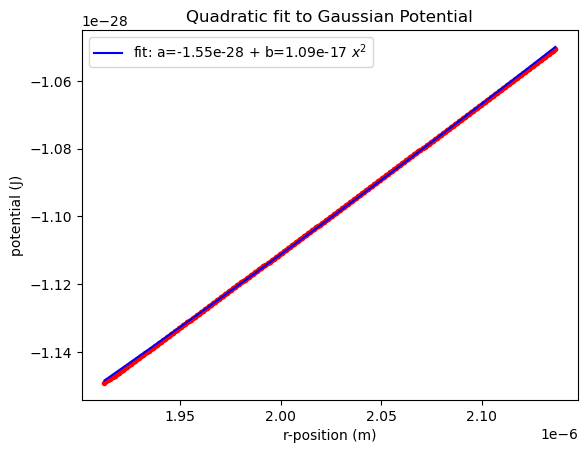

In [226]:
#fitting the potential vector to a quadratic function
from scipy import optimize

def poly(x,a,b):
    return a+b*(x**2)
xdata = r_pos
ydata = a

popt, pcov = optimize.curve_fit(poly, xdata, ydata)

print(popt,pcov)

plt.plot(xdata,ydata,'r.')
plt.plot(xdata,poly(xdata, *popt) ,'b-',label=f'fit: a={popt[0]:.2e} + b={popt[1]:.2e} $x^{{2}}$')
plt.xlabel("r-position (m)")
plt.ylabel("potential (J)")
plt.title("Quadratic fit to Gaussian Potential")
plt.legend()
plt.show()

In [227]:
#popt[1] should be 1/2*k, to get omega,w = sqrt(k/m)
fit = np.sqrt(2*popt[1]/m)
print(fit)

18090.443150938423


In [228]:
#testing out w = sqrt(2popt[1]/m*FWHM) -- idk why but this is wrong so wtv
np.sqrt((2*popt[1])/(m*FWHM))

8527916.684465528

In [230]:
#huh is the function that goes from the physical beam parameters to the tweezer trapping frequencies
#0th entry is radial and 1st entry is axial, I'm specifically calculating radial here 
#I thought the fit from above should match the frequency found from below, since it's using the same beam params
P0 = 5e-3
huh = tweezer_optical_potential_to_trap_frequency(lambda_beam,linewidths,omega_res,P0,FWHM,m)
print(huh[0])
print(fit/huh[0])

22156.72074805287
0.8164765606177624


In [231]:
print(huh[0]/(2*pi)*1e-3)

3.5263516297593713


In [75]:
trap_depth = potential(omega_tweezer,linewidths,omega_res,P0,FWHM)
print(trap_depth)

-1.6492209307882132e-28


In [76]:
#calculating the r-squared value of the fit
alpha_x = tuple(popt)[1]
residuals = ydata- poly(xdata, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)

0.9960501715859311


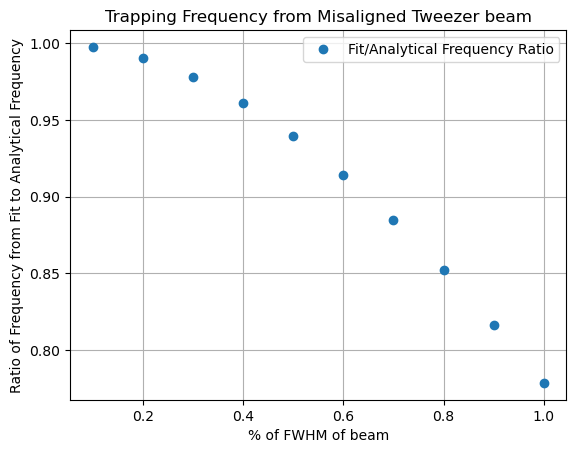

Dial: 0.10, Ratio of fit to analytical frequency: 1.00
Dial: 0.20, Ratio of fit to analytical frequency: 0.99
Dial: 0.30, Ratio of fit to analytical frequency: 0.98
Dial: 0.40, Ratio of fit to analytical frequency: 0.96
Dial: 0.50, Ratio of fit to analytical frequency: 0.94
Dial: 0.60, Ratio of fit to analytical frequency: 0.91
Dial: 0.70, Ratio of fit to analytical frequency: 0.88
Dial: 0.80, Ratio of fit to analytical frequency: 0.85
Dial: 0.90, Ratio of fit to analytical frequency: 0.82
Dial: 1.00, Ratio of fit to analytical frequency: 0.78


In [242]:

dial_values = np.arange(0.1, 1.1, 0.1)  
# List to store the results
results = []
ratios = []
P0 = 5e-3
FWHM = (4.5)*1e-6
z_pos = 0
lambda_beam = 532e-9

rayleigh = rayleigh_length(FWHM,lambda_beam)
beampropo = beam_propogation(FWHM,rayleigh,z_pos)
I_beam = intensity(P0,FWHM,beampropo,r_pos)
a = potential_position_dependent(omega_res,linewidths,omega_tweezer,I_beam)

# List to store the results
results = []
ratios = []
num_points = 2
for dial in dial_values:
    # Calculate r_pos for each dial value
    #r_pos = np.arange(0, (4.5 / 2) * (dial) * 1e-6, 0.02e-6)
    r_max = (FWHM / 2) * (dial+dial*0.025) 
    r_min = (FWHM / 2) * (dial-dial*0.025) 
    r_pos = np.linspace(r_min, r_max, num_points)

    # Recalculate ydata (a) for each dial value. This should match r_pos in length
    # Ensure that 'a' is recalculated or extracted for the same length as r_pos
    ydata = potential_position_dependent(omega_res, linewidths, omega_tweezer, intensity(P0, FWHM, beam_propogation(FWHM, rayleigh_length(FWHM, lambda_beam), z_pos), r_pos))

    # Check if xdata and ydata lengths match
    if len(r_pos) == len(ydata):
        xdata = r_pos

        # Perform the fit for the potential
        popt, pcov = optimize.curve_fit(poly, xdata, ydata)

        # Calculate the fit-based radial frequency
        fit = np.sqrt(2 * popt[1] / m)

        # Use the tweezer_optical_potential_to_trap_frequency function to get the analytical radial frequency
        huh = tweezer_optical_potential_to_trap_frequency(lambda_beam, linewidths, omega_res, P0, FWHM, m)

        # Append the dial value and the ratio of fit to analytical frequency to the results list
        ratio = fit / huh[0]
        results.append((dial, ratio))
        ratios.append(ratio)  # Collect ratios for plotting
    else:
        print(f"Skipping dial {dial}: Length mismatch between r_pos and ydata")

# Plot the dial values against the ratios
plt.plot(dial_values, ratios, 'o', label='Fit/Analytical Frequency Ratio')
plt.xlabel('% of FWHM of beam')
plt.ylabel('Ratio of Frequency from Fit to Analytical Frequency')
plt.title('Trapping Frequency from Misaligned Tweezer beam')
plt.legend()
plt.grid(True)
plt.show()

# Optionally print the results
for dial, ratio in results:
    print(f"Dial: {dial:.2f}, Ratio of fit to analytical frequency: {ratio:.2f}")


In [234]:
r_max = (FWHM) * (dial-dial*0.05) * 1e-6

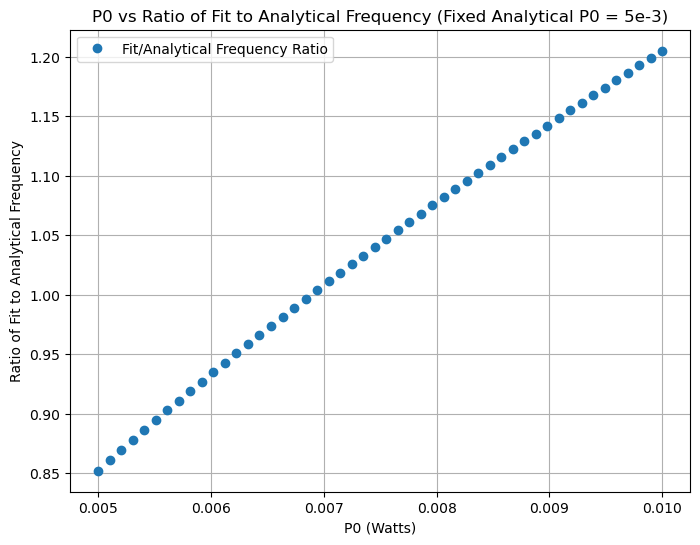

0.005714285714285714 0.9109226762084531


In [243]:
# Define the range for the P0 values (adjust the range and step size as needed)
P0_values = np.linspace(5e-3, 10e-3, 50)  # P0 values ranging from 1 mW to 10 mW

# Fixed dial value
dial = 0.8

# Fixed P0 for analytical frequency calculation
P0_analytical = 5e-3

# List to store the results
results = []
ratios = []

# Define a fixed number of points for r_pos
num_points = 50  # Fixed number of points for each P0 value

# Calculate the analytical frequency only once using P0_analytical
huh_analytical = tweezer_optical_potential_to_trap_frequency(lambda_beam, linewidths, omega_res, P0_analytical, FWHM, m)

for P0 in P0_values:
    # Calculate r_pos for the fixed dial value using a fixed number of points
    #r_max = (4.5 / 2) * dial * 1e-6  # Calculate maximum r_pos based on dial value
    #r_pos = np.linspace(0, r_max, num_points)  # Create r_pos with fixed number of points

    r_max = (FWHM / 2) * (dial+dial*0.025) 
    r_min = (FWHM / 2) * (dial-dial*0.025) 
    r_pos = np.linspace(r_min, r_max, num_points)

    # Recalculate ydata (a) for each P0 value. This should match r_pos in length
    ydata = potential_position_dependent(omega_res, linewidths, omega_tweezer, intensity(P0, FWHM, beam_propogation(FWHM, rayleigh_length(FWHM, lambda_beam), z_pos), r_pos))

    # Now xdata and ydata lengths should always match
    xdata = r_pos

    # Perform the fit for the potential
    popt, pcov = optimize.curve_fit(poly, xdata, ydata)

    # Calculate the fit-based radial frequency
    fit = np.sqrt(2 * popt[1] / m)

    # Append the P0 value and the ratio of fit to the fixed analytical frequency
    ratio = fit / huh_analytical[0]
    results.append((P0, ratio))
    ratios.append(ratio)  # Collect ratios for plotting

# Plot the P0 values against the ratios
plt.figure(figsize=(8, 6))
plt.plot(P0_values, ratios, 'o', label='Fit/Analytical Frequency Ratio')
plt.xlabel('P0 (Watts)')
plt.ylabel('Ratio of Fit to Analytical Frequency')
plt.title('P0 vs Ratio of Fit to Analytical Frequency (Fixed Analytical P0 = 5e-3)')
plt.legend()
plt.grid(True)
plt.show()
print(P0_values[7],ratios[7])

In [199]:
def pot_derivative_with_2tweeze(x, omega_rf_axial, omega_tw_radial, tweezed_ion1,tweezed_ion2, displacement1,displacement2):
    """
    derivative of the potential energy of the ion chain, use this to find positions of ions in the trap
    This one is specifically for tweezing one ion in the chain
    inputs:

    x: list of ion positions
    omega_rf_axial: the rf axial trapping frequency [2*pi*Hz]
    omega_tw_radial: the tweezer radial trapping frequency [2*pi*Hz]
    tweezed_ion: Ion number for the tweezed ion
    displacement: distance between the tweezer beam center and position of the tweezed ion
    """
    N = len(x)
    A = 1/2 * m * omega_rf_axial**2
    B = (e**2) /(4 * pi * eps0)
    C = 1/2 * m * omega_tw_radial**2
    
    return [A*(x[m]) 
            - sum([B / (abs(x[m] - x[n])**2) for n in range(m) if x[m] != x[n]])  # Avoid division by zero
            + sum([B / (abs(x[m] - x[n])**2) for n in range(m+1, N) if x[m] != x[n]])  # Avoid division by zero
            + C*(x[tweezed_ion1] - displacement1) if m == tweezed_ion1 else 0  # Only apply tweezer potential to the tweezed ion1
            + C*(x[tweezed_ion2] + displacement2) if m == tweezed_ion2 else 0  # Only apply tweezer potential to the tweezed ion2|
            for m in range(N)]

In [201]:
# Example usage
N = 3
x = np.empty(N)
omega_rf_axial = 1 * 2 * pi * 1e6
tweezer_wavelength = 532e-9
P0_analytical = 5e-3
beam_waist = 6e-6
omega_tw_radial = tweezer_optical_potential_to_trap_frequency(tweezer_wavelength,linewidths,omega_res,P0,beam_waist,m)[0]
print(omega_tw_radial)
tweezed_ion1 = 0
tweezed_ion2 = 1
displacement1 = ionspacing[1][0]
displacement2 = ionspacing[1][1]
ionspacing = ion_spacing(N,omega_rf_axial)
#print(ionspacing)


tweeze_on = fsolve(pot_derivative_with_2tweeze,ionspacing[0],args = (omega_rf_axial,omega_tw_radial,tweezed_ion1,tweezed_ion2,displacement1,displacement2))
print(tweeze_on)
print(ionspacing)
ionspacing[0] == fsolve(pot_derivative_with_2tweeze,ionspacing[0],args = (omega_rf_axial,omega_tw_radial,tweezed_ion1,tweezed_ion2,displacement1,displacement2))

17625.563426030465
[-5.84332026e-06 -2.99287457e-12  1.01910520e-05]
[array([-4.79258560e-06,  8.03686927e-20,  4.79258560e-06]), [4.792585602933644e-06, 4.792585602933404e-06]]


array([False, False, False])

In [202]:
ionspacing[0][1] - tweeze_on

array([ 5.84332026e-06,  2.99287465e-12, -1.01910520e-05])

In [189]:
ionspacing[1][0]/beam_waist

0.7987642671556073

In [8]:
#parameters you can change but I'm not going to right now
w_rf_r =2 *pi*1e6
w_rf_a = w_rf_r / 8

d_max = ion_spacing(N,w_rf_a)
print(d_max)
beam_waist = 1e-6

[array([-3.10170009e-05, -1.46302444e-05, -2.13071692e-17,  1.46302444e-05,
        3.10170009e-05]), [1.638675654886227e-05, 1.4630244367946768e-05, 1.4630244367936241e-05, 1.6386756548989853e-05]]


In [9]:
#now parameters we're changing

P_opt = np.linspace(0,1000,5)*1e-3 #going from 0 to 100 mW 
print(P_opt)

[0.   0.25 0.5  0.75 1.  ]


In [10]:
all_modes_0 = []

for j in range(len(P_opt)):
    all_modes_0.append(physical_params_to_radial_mode_vectors(N,[0],tweezer_wavelength,linewidths,omega_res,w_rf_a,w_rf_r,P_opt[j],beam_waist,m))

# Initialize empty lists for e_freqs and Modes
e_freqs_0 = [[] for _ in range(len(all_modes_0[0]))]
Modes_0 = [[] for _ in range(len(all_modes_0[0]))]


# Loop through the data and extract frequencies and modes
for i in range(len(all_modes_0)):
    for j in range(len(all_modes_0[i])):
        e_freqs_0[j].append(all_modes_0[i][j][0])
        Modes_0[j].append(all_modes_0[i][j][1]) 


In [11]:
all_modes_1 = []

for j in range(len(P_opt)):
    all_modes_1.append(physical_params_to_radial_mode_vectors(N,[1],tweezer_wavelength,linewidths,omega_res,w_rf_a,w_rf_r,P_opt[j],beam_waist,m))

# Initialize empty lists for e_freqs and Modes
e_freqs_1 = [[] for _ in range(len(all_modes_1[0]))]
Modes_1 = [[] for _ in range(len(all_modes_1[0]))]


# Loop through the data and extract frequencies and modes
for i in range(len(all_modes_1)):
    for j in range(len(all_modes_1[i])):
        e_freqs_1[j].append(all_modes_1[i][j][0])
        Modes_1[j].append(all_modes_1[i][j][1]) 


In [12]:
all_modes_2 = []

for j in range(len(P_opt)):
    all_modes_2.append(physical_params_to_radial_mode_vectors(N,[2],tweezer_wavelength,linewidths,omega_res,w_rf_a,w_rf_r,P_opt[j],beam_waist,m))

# Initialize empty lists for e_freqs and Modes
e_freqs_2 = [[] for _ in range(len(all_modes_2[0]))]
Modes_2 = [[] for _ in range(len(all_modes_2[0]))]


# Loop through the data and extract frequencies and modes
for i in range(len(all_modes_2)):
    for j in range(len(all_modes_2[i])):
        e_freqs_2[j].append(all_modes_2[i][j][0])
        Modes_2[j].append(all_modes_2[i][j][1]) 


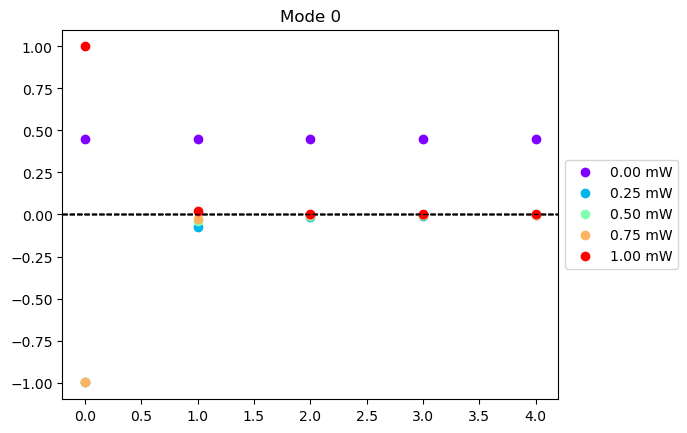

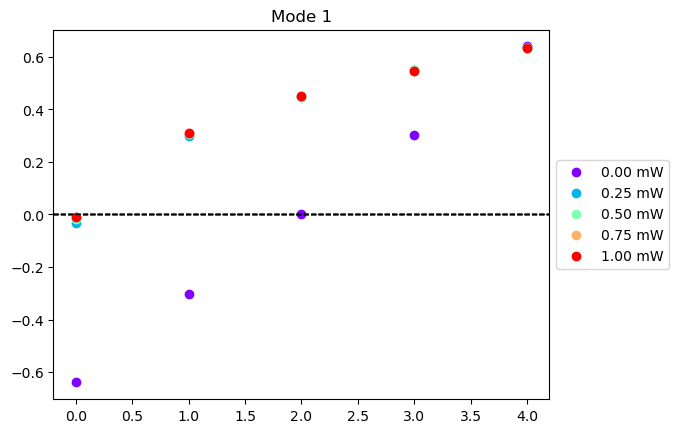

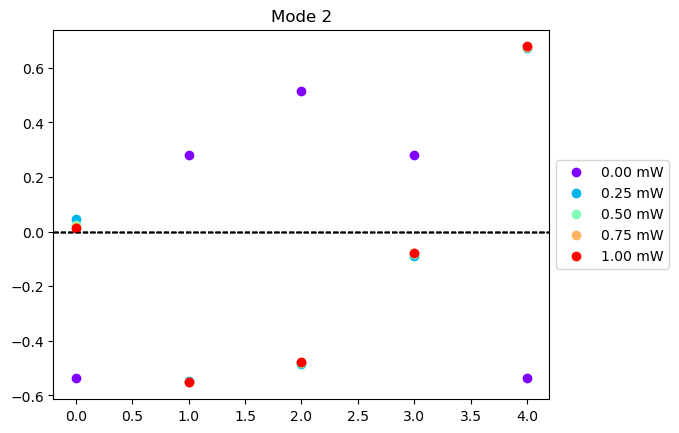

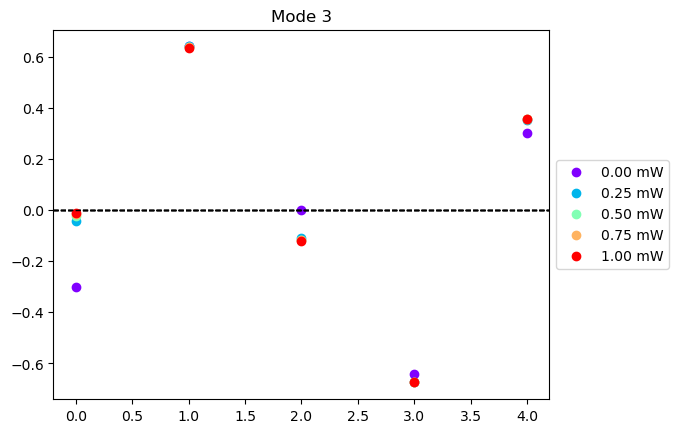

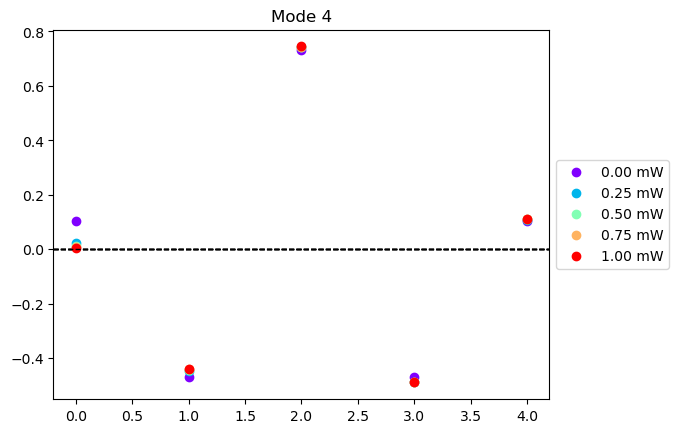

In [13]:
colors = plt.cm.rainbow(np.linspace(0, 1, len(P_opt)))

for mode_index in range(N):  # Assuming you have two modes to plot (Modes_0[0] and Modes_0[1])
    for i in range(len(P_opt)):
        plt.plot(Modes_0[mode_index][i], 'o', color=colors[i], label=f'{P_opt[i]:.2f} mW')
        plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Add horizontal line at y=0
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside the plot, on the right side
    plt.title(f'Mode {mode_index}')
    plt.show()



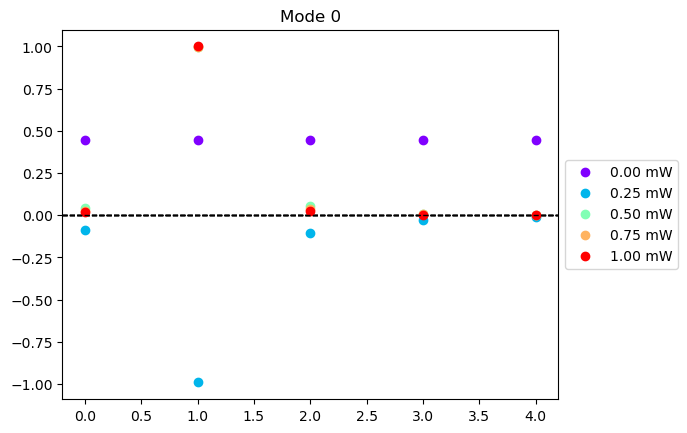

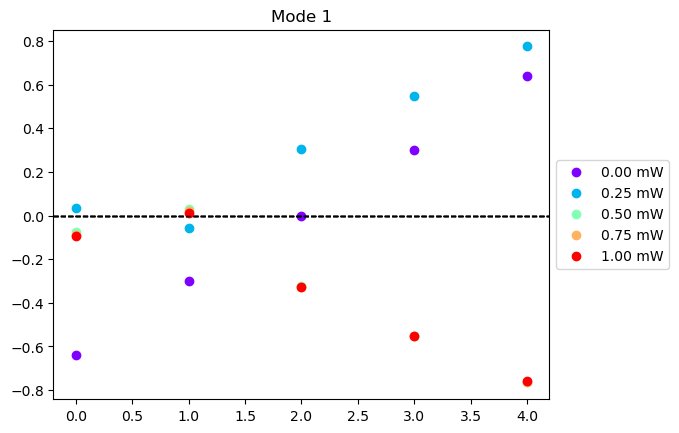

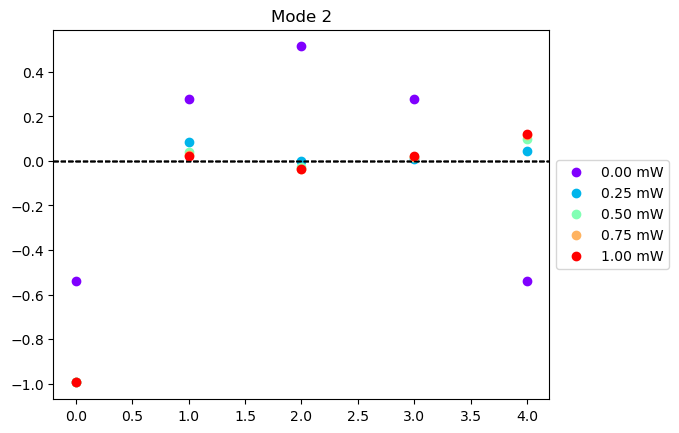

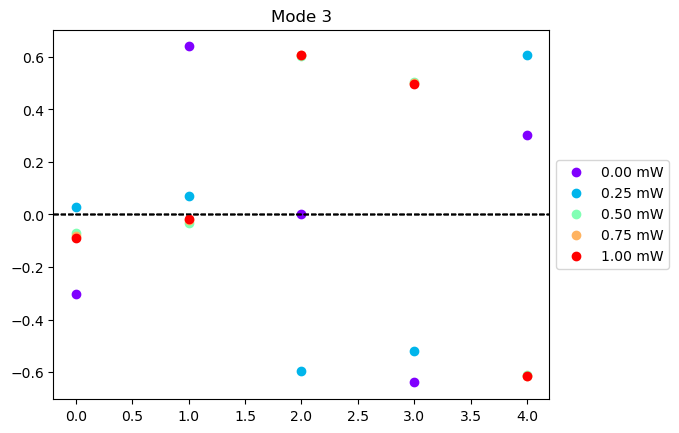

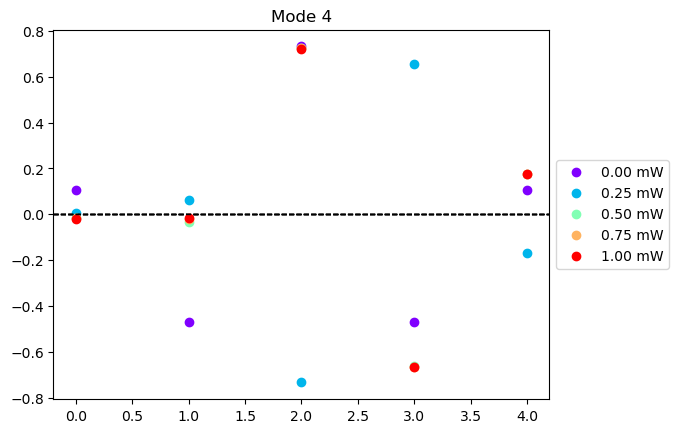

In [14]:
for mode_index in range(N):  # Assuming you have two modes to plot (Modes_0[0] and Modes_0[1])
    for i in range(len(P_opt)):
        plt.plot(Modes_1[mode_index][i], 'o', color=colors[i], label=f'{P_opt[i]:.2f} mW')
        plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Add horizontal line at y=0
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside the plot, on the right side
    plt.title(f'Mode {mode_index}')
    plt.show()



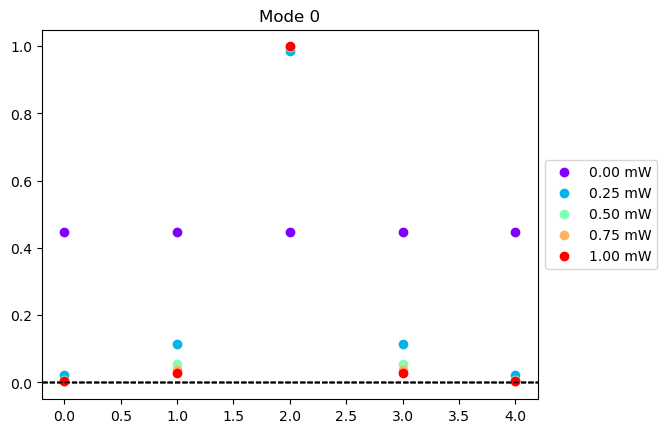

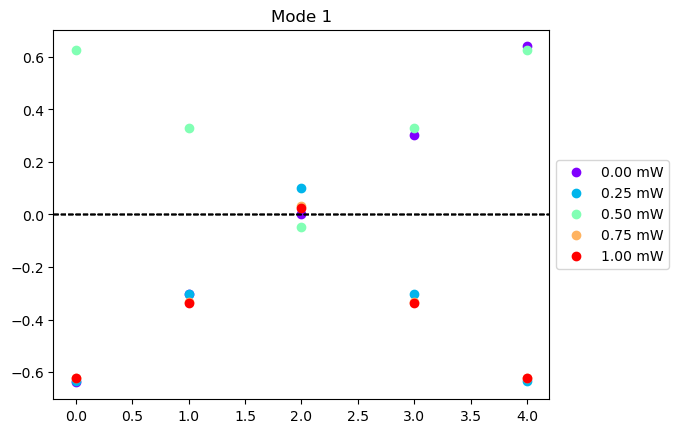

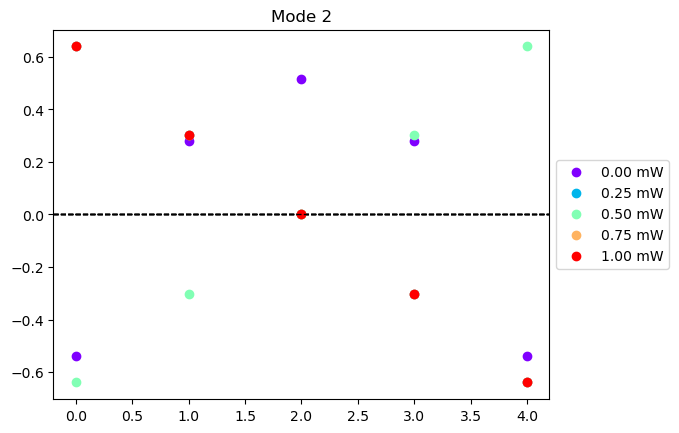

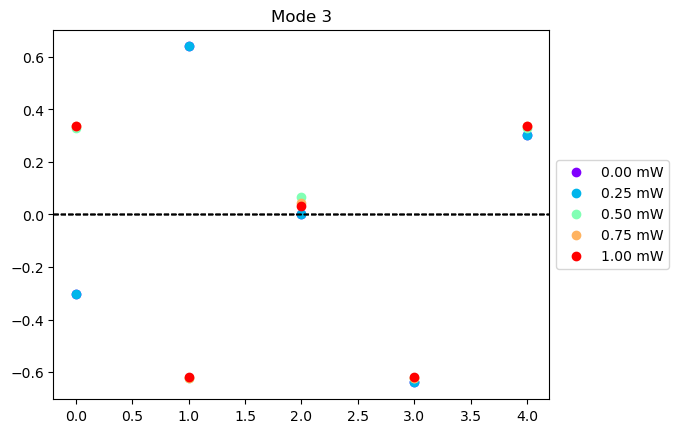

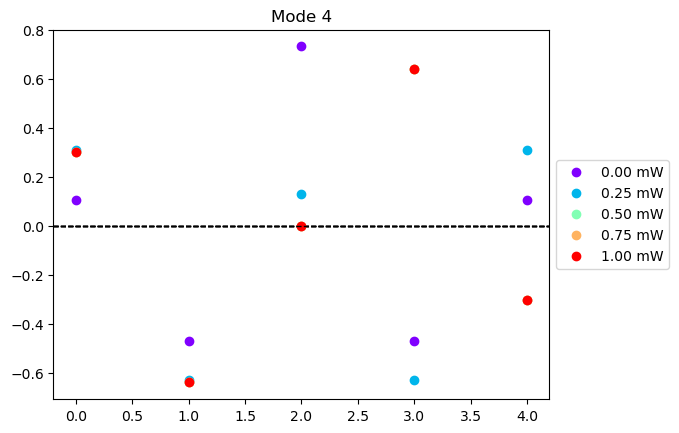

In [15]:
for mode_index in range(N):  # Assuming you have two modes to plot (Modes_0[0] and Modes_0[1])
    for i in range(len(P_opt)):
        plt.plot(Modes_2[mode_index][i], 'o', color=colors[i], label=f'{P_opt[i]:.2f} mW')
        plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Add horizontal line at y=0
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move legend outside the plot, on the right side
    plt.title(f'Mode {mode_index}')
    plt.show()

